In [1]:
!pip install minio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 197.7 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 502.4 kB/s eta 0:00:0000:0100:01


In [2]:
import pandas as pd
from sqlalchemy.engine import create_engine
from trino.dbapi import connect
conn = connect(
    host='trino',  # The hostname should match the service name in docker-compose
    port=8060,     # The Trino coordinator port
    user='trino',  # The username
    catalog='iceberg',  # The catalog
    schema='silver'  # The schema, adjust if you have a different schema
)

# Create a cursor object using the connection
cur = conn.cursor()

# Check if the 'default' schema exists, and create it if not
cur.execute("""
    SELECT DATE_TRUNC('month', o.order_purchase_timestamp) as month, SUM(f.price) as total_sales
    FROM Fact_Sales f
    JOIN Dim_Orders o ON f.order_id = o.order_id
    GROUP BY DATE_TRUNC('month', o.order_purchase_timestamp)
    ORDER BY DATE_TRUNC('month', o.order_purchase_timestamp)
""")
schemas = [schema[0] for schema in cur.fetchall()]
print(schemas)

[datetime.datetime(2016, 9, 1, 0, 0), datetime.datetime(2016, 10, 1, 0, 0), datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2017, 2, 1, 0, 0), datetime.datetime(2017, 3, 1, 0, 0), datetime.datetime(2017, 4, 1, 0, 0), datetime.datetime(2017, 5, 1, 0, 0), datetime.datetime(2017, 6, 1, 0, 0), datetime.datetime(2017, 7, 1, 0, 0), datetime.datetime(2017, 8, 1, 0, 0), datetime.datetime(2017, 9, 1, 0, 0), datetime.datetime(2017, 10, 1, 0, 0), datetime.datetime(2017, 11, 1, 0, 0), datetime.datetime(2017, 12, 1, 0, 0), datetime.datetime(2018, 1, 1, 0, 0), datetime.datetime(2018, 2, 1, 0, 0), datetime.datetime(2018, 3, 1, 0, 0), datetime.datetime(2018, 4, 1, 0, 0), datetime.datetime(2018, 5, 1, 0, 0), datetime.datetime(2018, 6, 1, 0, 0), datetime.datetime(2018, 7, 1, 0, 0), datetime.datetime(2018, 8, 1, 0, 0)]


In [3]:
%pip install jupysql trino pandas pyarrow --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install sqlalchemy-trino --quiet

Note: you may need to restart the kernel to use updated packages.


In [5]:
from time import time
from sqlalchemy import create_engine
engine = create_engine('trino://trino@trino:8060/iceberg')

In [6]:
%load_ext sql

Deploy Flask apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


In [7]:
%sql trino://trino@trino:8060/iceberg

Connecting to 'trino://trino@trino:8060/iceberg'

In [8]:
%sqlcmd tables --schema bronze

EXECUTE IMMEDIATE not available for trino:8060; defaulting to legacy prepared statements (TrinoUserError(type=USER_ERROR, name=SYNTAX_ERROR, message="line 1:19: mismatched input ''SELECT 1''. Expecting: 'USING', <EOF>", query_id=20240604_231844_00015_k9ii2))


Name
customers
geolocation
order_items
order_payments
order_reviews
orders
product_category_name_translation
products
sellers


In [9]:
%sqlcmd tables --schema silver

Name
dim_customers
dim_geolocation
dim_orders
dim_products
dim_sellers
fact_sales


In [10]:
%sqlcmd columns --table products --schema bronze

name,type,nullable,default
product_id,VARCHAR,True,None
product_category_name,VARCHAR,True,None
product_name_length,INTEGER,True,None
product_description_length,INTEGER,True,None
product_photos_qty,INTEGER,True,None
product_weight_g,INTEGER,True,None
product_length_cm,INTEGER,True,None
product_height_cm,INTEGER,True,None
product_width_cm,INTEGER,True,None


In [11]:
%%sql
SELECT COUNT(*) FROM iceberg.bronze.order_items

Running query in 'trino://trino@trino:8060/iceberg'

_col0
112650


In [12]:
!pip install lightgbm


In [13]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = %sql SELECT oi.price, oi.freight_value, op.payment_value FROM iceberg.bronze.order_items AS oi JOIN iceberg.bronze.order_payments AS op ON oi.order_id = op.order_id

df = data.DataFrame()
print(df.head(n = 5))
df = df.dropna()

# Define predictor variables (X) and target variable (y)
X = df[['price', 'freight_value']]
y = df['payment_value']

Running query in 'trino://trino@trino:8060/iceberg'

    price  freight_value  payment_value
0   58.90          13.29          72.19
1  239.90          19.93         259.83
2  199.00          17.87         216.87
3   12.99          12.79          25.78
4  199.90          18.14         218.04


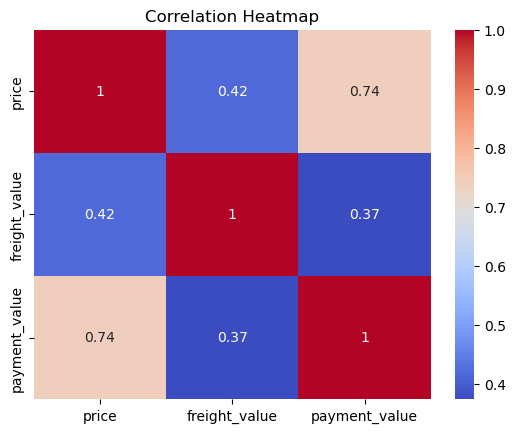

In [14]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [15]:
# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
# Create a LightGBM model
model = LGBMRegressor()

# Train the model
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 94080, number of used features: 2
[LightGBM] [Info] Start training from score 172.950802


LGBMRegressor()

Mean Absolute Error: 60.131601671086194
Mean Squared Error: 23406.599835291814
Root Mean Squared Error: 152.99215612341638


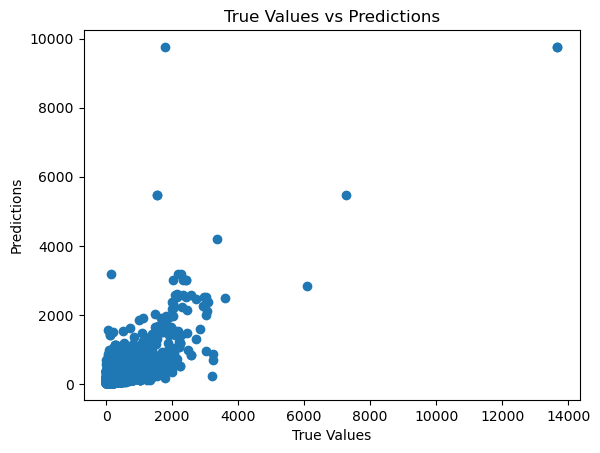

In [17]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# Plot the true values vs predictions
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

In [18]:
%%sql
SELECT * FROM iceberg.bronze.products

Running query in 'trino://trino@trino:8060/iceberg'

product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
"""00066f42aeeb9f3007548bb9d3f33c3",perfumaria,53,596,6,300,20,16,16
"""00088930e925c41fd95ebfe695fd265",automotivo,56,752,4,1225,55,10,26
"""0009406fd7479715e4bef61dd91f246",cama_mesa_banho,50,266,2,300,45,15,35
"""000b8f95fcb9e0096488278317764d1",utilidades_domesticas,25,364,3,550,19,24,12
"""000d9be29b5207b54e86aa1b1ac5487",relogios_presentes,48,613,4,250,22,11,15
"""0011c512eb256aa0dbbb544d8dffcf6",automotivo,58,177,1,100,16,15,16
"""00126f27c813603687e6ce486d909d0",cool_stuff,42,2461,1,700,25,5,15
"""001795ec6f1b187d37335e1c4704762",consoles_games,53,274,1,600,30,20,20
"""001b237c0e9bb435f2e54071129237e",cama_mesa_banho,42,253,1,6000,40,4,30
"""001b72dfd63e9833e8c02742adf472e",moveis_decoracao,45,520,3,600,26,8,22
